<a id="content"><h3>Content</h3></a>

[Dependencies, paths and datasets upload](#upload)\
[Mouse clustering preprocess](#preprocess_mouse)\
[Human clustering preprocess](#preprocess_human)\
[Best silhouette score calculation and plotting for mouse](#silhouette_mouse)\
[Best silhouette score calculation and plotting for human](#silhouette_human)\
[Applying best n_clusters for human and mouse and labeling the terms](#best_silhouette)\
[Distance between each low-level terms pair distribution](#distances)\
[Cluster analysis: mean distance within each cluster calculation](#cluster_distance)\
[Distance within clusters computation](#distances_within)\
[Visualization](#visualization)

<a id="upload"><h4>Dependencies, paths and datasets upload</h4></a>
[Back to content](#content)

In [3]:
#!/usr/bin/env python3

import os
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
# Create directories for plots and intermediate data
PLOTS_DIR = "../pictures"
INTERMEDIATE_DATA_DIR = "../intermediate_data"
PATH_HPO = os.path.abspath("../ontologies/hpo.json")
PATH_MPO = os.path.abspath("../ontologies/mpo.json")

# function for further work with dataset
def isnan(x):
    return x != x

In [3]:
# dataset upload

data = pd.read_csv(
    "../databases/human_mouse_GPO_mono.tsv",
    delimiter="\t"
)

data.head()

,gene_human,entrez_id_human,gene_mouse,MGI,MP_HMD,MP_PhenoGeno,HP_genes_to_phenotype,MP_system_level,HP_system_level,MP_from_HP_system_level
0,A1BG,1,A1bg,MGI:2152878,NaN,NaN,NaN,NaN,NaN,NaN
1,A1CF,29974,A1cf,MGI:1917115,"MP:0005370,MP:0005376,MP:0005385,MP:0005397,MP...","MP:0006142,MP:0002833,MP:0004090,MP:0004084,MP...",NaN,"MP:0005370,MP:0005376,MP:0005385,MP:0005389,MP...",NaN,NaN
2,A2M,2,A2m,MGI:2449119,NaN,NaN,NaN,NaN,NaN,NaN
3,A3GALT2,127550,A3galt2,MGI:2685279,NaN,NaN,NaN,NaN,NaN,NaN
4,A4GALT,53947,A4galt,MGI:3512453,"MP:0010768,MP:0005376,MP:0005386","MP:0009747,MP:0008874,MP:0009767","HP:0000006,HP:0010970","MP:0010768,MP:0005376,MP:0005386",HP:0001871,MP:0005397


<a id="preprocess_mouse"><h4>Mouse clustering preprocess</h4></a>
[Back to content](#content)

In [7]:
# All low-level MPs list

mp_exists = data[
    data.MP_PhenoGeno\
        .apply(lambda x: not isnan(x))
]

mps_low_raw = mp_exists.MP_PhenoGeno\
    .apply(lambda x: x.split(","))\
    .tolist()

mps_low = list(set(list(itertools.chain(*mps_low_raw))))

In [8]:
# Dict MP low-level term: gene list creation

mouse_gene_pheno = [
    mp_exists.gene_human.tolist(),
    mp_exists.MP_PhenoGeno.tolist()
]

mouse_mps_dict = defaultdict(list)

for idx in range(len(mouse_gene_pheno[0])):
    gene = mouse_gene_pheno[0][idx]
    mps = mouse_gene_pheno[1][idx]

    for mp in mps.split(","):
        mouse_mps_dict[mp].append(gene)

In [9]:
# Jaccard indexes for each low-level MP pair count

jcrd_m_m = [[]]

for mp_1 in mps_low:
    jcrd_line = []
    for mp_2 in mps_low:
        jcrd_val = len(
            set(mouse_mps_dict[mp_1]).intersection(set(mouse_mps_dict[mp_2]))
        ) / len(set(mouse_mps_dict[mp_1]).union(set(mouse_mps_dict[mp_2])))
        jcrd_line.append(jcrd_val)
    jcrd_m_m.extend([jcrd_line])

jcrd_mouse_mouse = pd.DataFrame(
    jcrd_m_m[1:], 
    columns=mps_low, 
    index=mps_low
)

In [ ]:
# convert jaccard indexes to distances and save to csv

jcrd_distances_mouse = 1 - jcrd_mouse_mouse

jcrd_distances_mouse.to_csv(
    "../intermediate_data/clustering_mouse_low.csv"
)

<a id="preprocess_human"><h4>Human clustering preprocess</h4></a>
[Back to content](#content)

In [ ]:
# All low-level HPs list

hp_exists = data[
    data.HP_genes_to_phenotype\
        .apply(lambda x: not isnan(x))
]

hps_low_raw = hp_exists.HP_genes_to_phenotype\
    .apply(lambda x: x.split(","))\
    .tolist()

hps_low = list(set(list(itertools.chain(*hps_low_raw))))

In [ ]:
# Dict HP low-level term: gene list creation

human_gene_pheno = [
    hp_exists.gene_human.tolist(),
    hp_exists.HP_genes_to_phenotype.tolist()
]

human_hps_dict = defaultdict(list)

for idx in range(len(human_gene_pheno[0])):
    gene = human_gene_pheno[0][idx]
    hps = human_gene_pheno[1][idx]

    for hp in hps.split(","):
        human_hps_dict[hp].append(gene)

In [ ]:
# Jaccard indexes for each low-level HP pair count

jcrd_h_h = [[]]

for hp_1 in hps_low:
    jcrd_line = []
    for hp_2 in hps_low:
        jcrd_val = len(
            set(human_hps_dict[hp_1]).intersection(set(human_hps_dict[hp_2]))
        ) / len(set(human_hps_dict[hp_1]).union(set(human_hps_dict[hp_2])))
        jcrd_line.append(jcrd_val)
    jcrd_h_h.extend([jcrd_line])

jcrd_human_human = pd.DataFrame(
    jcrd_h_h[1:], 
    columns=hps_low, 
    index=hps_low
)

In [ ]:
# convert jaccard indexes to distances and save to csv

jcrd_distances_human = 1 - jcrd_human_human

jcrd_distances_human.to_csv(
    "../intermediate_data/clustering_human_low.csv"
)

<a id="silhouette_mouse"><h4>Best silhouette score calculation for mouse</h4></a>
[Back to content](#content)

In [12]:
mouse_distances.head()

,MP:0004175,MP:0030200,MP:0012304,MP:0001176,MP:0000021,MP:0003197,MP:0004243,MP:0002379,MP:0008363,MP:0009980,...,MP:0005176,MP:0000423,MP:0000741,MP:0010734,MP:0020356,MP:0001034,MP:0004062,MP:0000217,MP:0012365,MP:0020568
MP:0004175,0.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0030200,1.0,0.000000,1.0,0.993056,1.0,1.0,1.0,1.0,1.0,1.0,...,0.975000,1.000000,1.0,1.0,1.000000,0.941176,1.0,1.0,1.0,1.0
MP:0012304,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0001176,1.0,0.993056,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.987654,0.972414,1.0,1.0,0.985915,0.985612,1.0,1.0,1.0,1.0
MP:0000021,1.0,1.000000,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0


In [13]:
# Find the optimal number of clusters

mouse_sil = []

best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range(2, mouse_distances.shape[0], 50):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(mouse_distances)

    silhouette_avg = silhouette_score(mouse_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    mouse_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"The optimal number of clusters is {best_n_clusters}")
print(f"The silhouette score is {best_silhouette_score}")

The optimal number of clusters is 5952
The silhouette score is 0.12537603328470298


In [14]:
# silhouette score clarification

for n_clusters in range(5900, 6000):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(mouse_distances)

    silhouette_avg = silhouette_score(mouse_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    mouse_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"The optimal number of clusters is {best_n_clusters}")
print(f"The silhouette score is {best_silhouette_score}")

The optimal number of clusters is 5936
The silhouette score is 0.12542900350235936


In [33]:
np.min(np.array(mouse_sil)[:, 1])

-0.02022507682965622

''

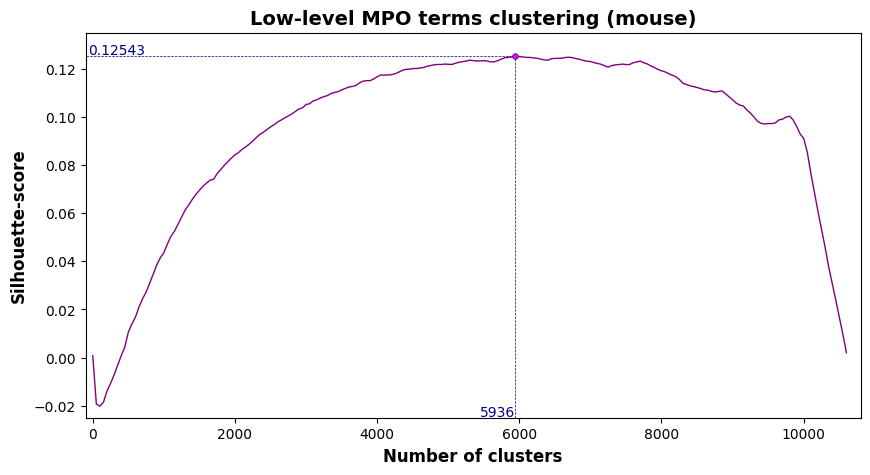

In [113]:
plt.figure(figsize=(10, 5))

clusters = np.array(mouse_sil)[:, 0]
silhouettes = np.array(mouse_sil)[:, 1]
sns.lineplot(
    x=clusters, 
    y=silhouettes,
    linewidth=1,
    color="purple"
)

ymin, ymax = -0.025, 0.135
plt.ylim(ymin, ymax)
xmin, xmax = -100, 10800
plt.xlim(xmin, xmax)

ymaxline = (best_silhouette_score - np.min(silhouettes)) / (ymax - np.min(silhouettes))
xmaxline = (best_n_clusters - np.min(clusters)) / (xmax - np.min(clusters))

lineset = {
    "linestyle": "--",
    "linewidth": 0.5,
    "color": "navy"
}

plt.axvline(
    x=best_n_clusters,
    ymax=ymaxline,
    **lineset
)
plt.axhline(
    y=best_silhouette_score,
    xmax=xmaxline,
    **lineset
)

plt.plot(
    best_n_clusters, 
    best_silhouette_score,
    color="magenta",
    marker="o",
    markersize=4,
    markeredgecolor="navy", 
    markeredgewidth=0.5
)

plt.annotate(
    text=best_n_clusters,
    xy=(best_n_clusters, ymin + 0.0005),
    ha="right",
    color="navy"
)
plt.annotate(
    text=f"{best_silhouette_score:.5f}",
    xy=(xmin + 30, best_silhouette_score + 0.0005),
    color="navy"
)

plt.xlabel(
    "Number of clusters",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Silhouette-score",
    size=12,
    weight="semibold"
)
plt.title(
    "Low-level MPO terms clustering (mouse)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_24_mouse_clustering",
    bbox_inches="tight",
    dpi=800
)
("")

<a id="silhouette_human"><h4>Best silhouette score calculation and plotting for human</h4></a>
[Back to content](#content)

In [100]:
# Find the optimal number of clusters

human_sil = []

best_n_clusters_2 = 2
best_silhouette_score_2 = -1

for n_clusters in range(2, human_distances.shape[0], 50):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(human_distances)

    silhouette_avg = silhouette_score(human_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    human_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score_2:
        best_silhouette_score_2 = silhouette_avg
        best_n_clusters_2 = n_clusters

print(f"The optimal number of clusters is {best_n_clusters_2}")
print(f"The silhouette score is {best_silhouette_score_2}")

The optimal number of clusters is 4902
The silhouette score is 0.2523610005016924


In [101]:
# silhouette score clarification

for n_clusters in range(4850, 5000):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(human_distances)

    silhouette_avg = silhouette_score(human_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    human_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score_2:
        best_silhouette_score_2 = silhouette_avg
        best_n_clusters_2 = n_clusters

print(f"The optimal number of clusters is {best_n_clusters_2}")
print(f"The silhouette score is {best_silhouette_score_2}")

The optimal number of clusters is 4900
The silhouette score is 0.25238565153918135


''

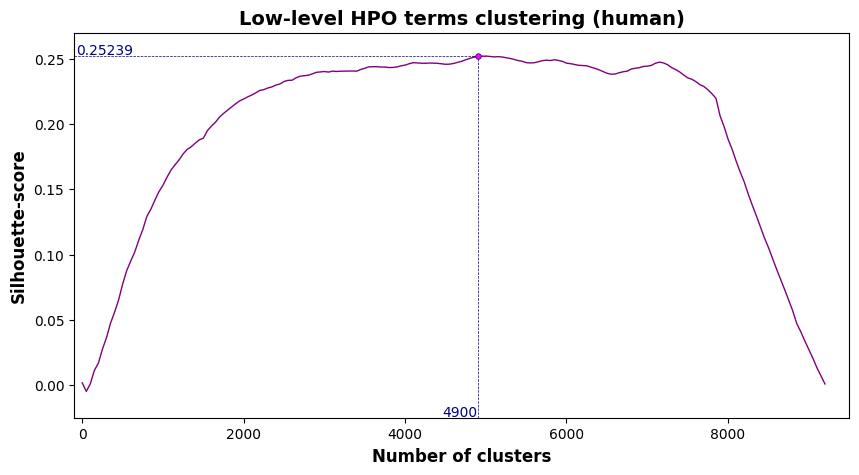

In [114]:
plt.figure(figsize=(10, 5))

clusters = np.array(human_sil)[:, 0]
silhouettes = np.array(human_sil)[:, 1]
sns.lineplot(
    x=clusters, 
    y=silhouettes,
    linewidth=1,
    color="purple"
)

ymin, ymax = -0.025, 0.27
plt.ylim(ymin, ymax)
xmin, xmax = -100, 9500
plt.xlim(xmin, xmax)

ymaxline = (best_silhouette_score_2 - np.min(silhouettes)) / (ymax - np.min(silhouettes))
xmaxline = (best_n_clusters_2 - np.min(clusters)) / (xmax - np.min(clusters))

lineset = {
    "linestyle": "--",
    "linewidth": 0.5,
    "color": "navy"
}

plt.axvline(
    x=best_n_clusters_2,
    ymax=ymaxline,
    **lineset
)
plt.axhline(
    y=best_silhouette_score_2,
    xmax=xmaxline,
    **lineset
)

plt.plot(
    best_n_clusters_2, 
    best_silhouette_score_2,
    color="magenta",
    marker="o",
    markersize=4,
    markeredgecolor="navy", 
    markeredgewidth=0.5
)

plt.annotate(
    text=best_n_clusters_2,
    xy=(best_n_clusters_2, ymin + 0.001),
    ha="right",
    color="navy"
)
plt.annotate(
    text=f"{best_silhouette_score_2:.5f}",
    xy=(xmin + 30, best_silhouette_score_2 + 0.001),
    color="navy"
)

plt.xlabel(
    "Number of clusters",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Silhouette-score",
    size=12,
    weight="semibold"
)
plt.title(
    "Low-level HPO terms clustering (human)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_25_human_clustering",
    bbox_inches="tight",
    dpi=800
)
("")

<a id="best_silhouette"><h4>Applying best n_clusters for human and mouse and labeling the terms</h4></a>
[Back to content](#content)

In [17]:
best_n_clusters_m, best_n_clusters_h = 5936, 4900

In [18]:
clustering_m = AgglomerativeClustering(n_clusters=best_n_clusters_m, 
                                         metric='precomputed', 
                                         linkage='complete')
cluster_labels_m = clustering_m.fit_predict(mouse_distances)

In [19]:
dissimilarities_m = np.max(mouse_distances) - mouse_distances

mds_m = MDS(n_components=2, dissimilarity='precomputed')
coordinates_m = mds_m.fit_transform(dissimilarities_m)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


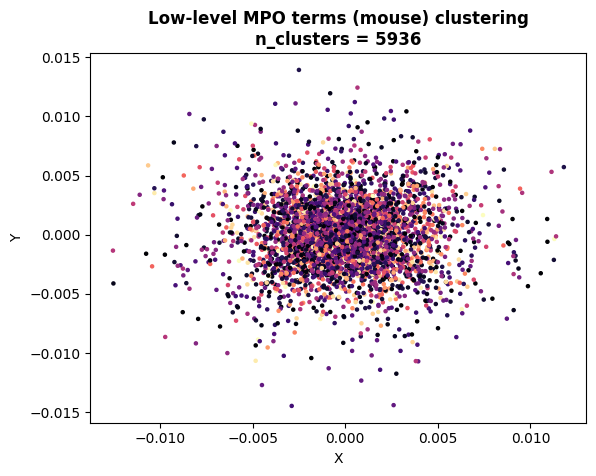

In [41]:
# plotting MPO terms with labels as colormap

# palette = sns.blend_palette(["navy", "crimson", "deeppink", "blueviolet"], as_cmap=True)

plt.scatter(
    coordinates_m[:, 0], 
    coordinates_m[:, 1],
    s=5, 
    c=cluster_labels_m,
    cmap="magma"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_26_mouse_cluster_labels",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [20]:
clustering_h = AgglomerativeClustering(n_clusters=best_n_clusters_h, 
                                         metric='precomputed', 
                                         linkage='complete')
cluster_labels_h = clustering_h.fit_predict(human_distances)

dissimilarities_h = np.max(human_distances) - human_distances

mds_h = MDS(n_components=2, dissimilarity='precomputed')
coordinates_h = mds_h.fit_transform(dissimilarities_h)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


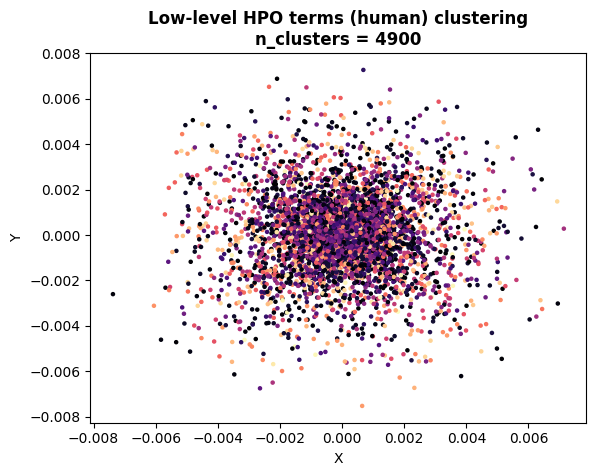

In [44]:
# plotting MPO terms with labels as colormap

plt.scatter(
    coordinates_h[:, 0], 
    coordinates_h[:, 1],
    s=5, 
    c=cluster_labels_h,
    cmap="magma"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_27_human_cluster_labels",
    bbox_inches="tight",
    dpi=800
)

plt.show()

<a id="distances"><h4>Distance between each low-level terms pair distribution</h4></a>
[Back to content](#content)

In [5]:
mouse_distances = pd.read_csv(
    "../intermediate_data/clustering_mouse_low.csv",
    index_col=0
)

mouse_distances.head()

,MP:0004175,MP:0030200,MP:0012304,MP:0001176,MP:0000021,MP:0003197,MP:0004243,MP:0002379,MP:0008363,MP:0009980,...,MP:0005176,MP:0000423,MP:0000741,MP:0010734,MP:0020356,MP:0001034,MP:0004062,MP:0000217,MP:0012365,MP:0020568
MP:0004175,0.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0030200,1.0,0.000000,1.0,0.993056,1.0,1.0,1.0,1.0,1.0,1.0,...,0.975000,1.000000,1.0,1.0,1.000000,0.941176,1.0,1.0,1.0,1.0
MP:0012304,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0001176,1.0,0.993056,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.987654,0.972414,1.0,1.0,0.985915,0.985612,1.0,1.0,1.0,1.0
MP:0000021,1.0,1.000000,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0


In [6]:
human_distances = pd.read_csv(
    "../intermediate_data/clustering_human_low.csv",
    index_col=0
)

human_distances.head()

,HP:0000190,HP:0005793,HP:0045028,HP:0001115,HP:0012330,HP:0025402,HP:0032531,HP:0030690,HP:0000751,HP:0031404,...,HP:0003193,HP:0030280,HP:0006673,HP:0006895,HP:0004444,HP:0032558,HP:0010906,HP:0100009,HP:0011109,HP:0009019
HP:0000190,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.956522,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.987179,1.0
HP:0005793,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0045028,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0001115,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0012330,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,0.980769,1.0,1.0,1.0,1.0,1.000000,1.0


In [59]:
array_m = mouse_distances.values.flatten()
filt_arr_m = array_m[(array_m != 0) & (array_m != 1)]
filt_arr_m_2 = filt_arr_m[filt_arr_m < 0.5]

print("Mouse MPO-MPO terms similarity numbers.")
print(f"Number of MPO term - MPO term similarity values is {len(array_m)}.")
print(f"Number of non 0 and non 1 similarity values is {len(filt_arr_m)}.")
print(f"Number of non 0 and < 0.5 similarity values is {len(filt_arr_m_2)}.")

Mouse MPO-MPO terms similarity numbers.
Number of MPO term - MPO term similarity values is 113039424.
Number of non 0 and non 1 similarity values is 11630170.
Number of non 0 and < 0.5 similarity values is 828.


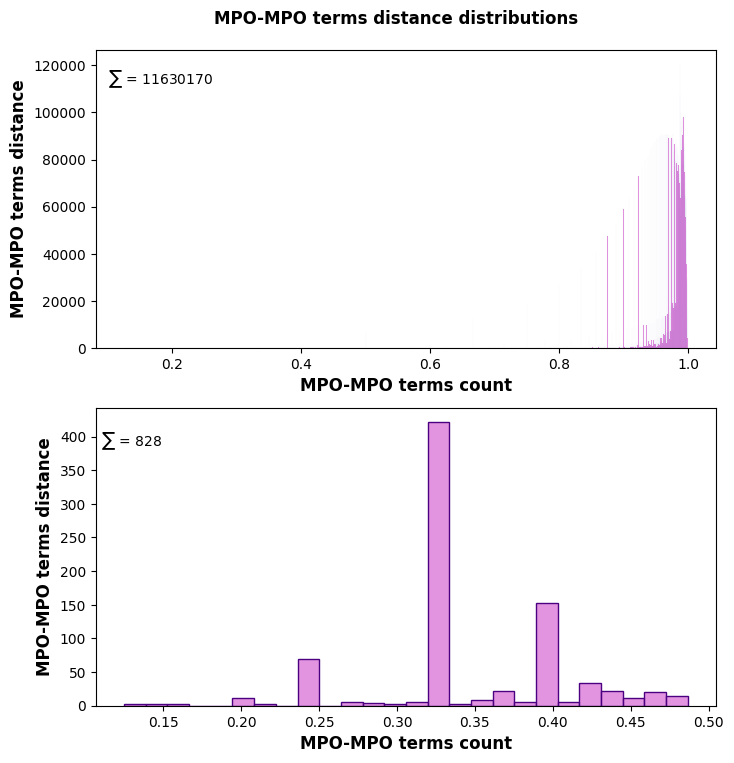

In [57]:
plt.figure(figsize=(8, 8))

dist_set = {
    "color": "orchid",
    "edgecolor": "indigo"
}

plt.subplot(2, 1, 1)

sns.histplot(
    filt_arr_m,
    **dist_set
)

plt.xlabel(
    "MPO-MPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "MPO-MPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.1, 119000,
    s=fr"$\sum$ = {len(filt_arr_m)}",
    ha='left', va='top'
)

plt.subplot(2, 1, 2)

sns.histplot(
    filt_arr_m_2,
    **dist_set
)

plt.xlabel(
    "MPO-MPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "MPO-MPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.11, 410,
    s=fr"$\sum$ = {len(filt_arr_m_2)}",
    ha='left', va='top'
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "MPO-MPO terms distance distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_28_MPO_interactions_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [60]:
array_h = human_distances.values.flatten()
filt_arr_h = array_h[(array_h != 0) & (array_h != 1)]
filt_arr_h_2 = filt_arr_h[filt_arr_h < 0.5]

print("Mouse HPO-HPO similarity numbers.")
print(f"Number of HPO term - HPO term similarity values is {len(array_h)}.")
print(f"Number of non 0 and non 1 similarity values is {len(filt_arr_h)}.")
print(f"Number of non 0 and < 0.5 similarity values is {len(filt_arr_h_2)}.")

Mouse HPO-HPO similarity numbers.
Number of HPO term - HPO term similarity values is 84824100.
Number of non 0 and non 1 similarity values is 5357684.
Number of non 0 and < 0.5 similarity values is 6960.


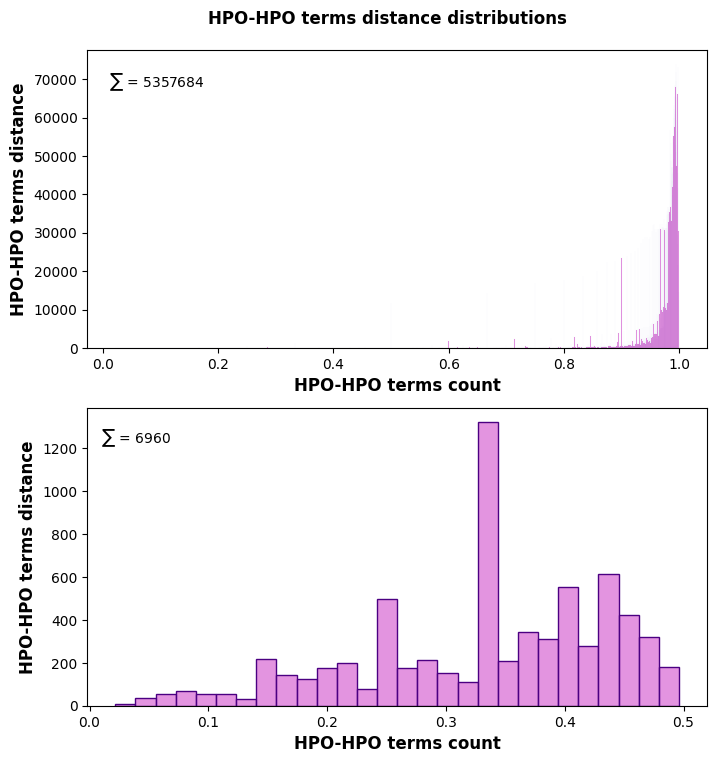

In [64]:
plt.figure(figsize=(8, 8))

dist_set = {
    "color": "orchid",
    "edgecolor": "indigo"
}

plt.subplot(2, 1, 1)

sns.histplot(
    filt_arr_h,
    **dist_set
)

plt.xlabel(
    "HPO-HPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "HPO-HPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.01, 72000,
    s=fr"$\sum$ = {len(filt_arr_h)}",
    ha='left', va='top'
)

plt.subplot(2, 1, 2)

sns.histplot(
    filt_arr_h_2,
    **dist_set
)

plt.xlabel(
    "HPO-HPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "HPO-HPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.01, 1300,
    s=fr"$\sum$ = {len(filt_arr_h_2)}",
    ha='left', va='top'
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "HPO-HPO terms distance distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_29_HPO_interactions_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

<a id="cluster_distance"><h4>Cluster analysis: mean distance within each cluster calculation</h4></a>
[Back to content](#content)

In [108]:
# Mouse

print(len(cluster_labels_m))
print(mouse_distances.shape)
print(len(np.unique(cluster_labels_m)))

10632
(10632, 10632)
5936


In [39]:
# mean distance within each cluster calculation
# [cluster id, mean distance within cluster, cluster size, cluster terms]

distance_means_m = []

for cluster_id in range(len(np.unique(cluster_labels_m))):
    rows_n_columns = np.where(cluster_labels_m == cluster_id)[0] # get indices of MPs within cluster
    df = mouse_distances.iloc[rows_n_columns, rows_n_columns] # slice the df
    array = df.to_numpy() # convert to numpy
    diagonal_indices = np.diag_indices(array.shape[0]) # get indices of diagonales
    np.fill_diagonal(array, np.nan) # diagonales -> nan
    mean = np.nanmean(array) # mean of distances
    size = len(rows_n_columns) # number of terms in cluster
    terms = ",".join(df.columns.tolist()) # cluster terms
    distance_means_m.append([cluster_id, mean, size, terms])

/tmp/ipykernel_6781/1043446138.py:12: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(array) # mean of distances


/tmp/ipykernel_6781/3484416186.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


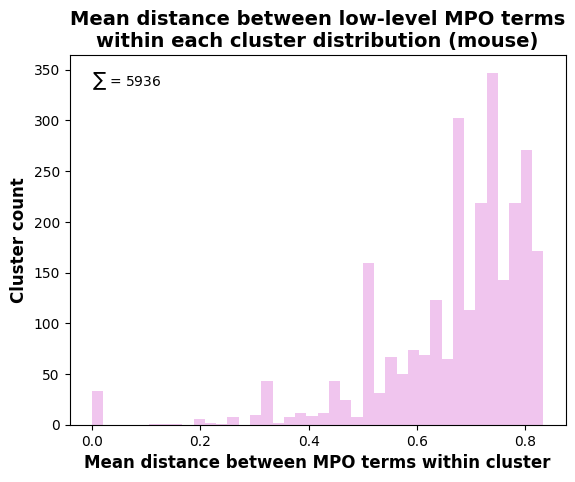

In [103]:
sns.distplot(
    np.array(distance_means_m)[:, 1],
    color="orchid",
    kde=False
)

plt.xlabel(
    "Mean distance between MPO terms within cluster",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="semibold"
)
plt.text(
    0, 350,
    s=fr"$\sum$ = {len(np.unique(cluster_labels_m))}",
    ha='left', va='top'
)

plt.title(
    "Mean distance between low-level MPO terms\nwithin each cluster distribution (mouse)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_30_MPO_distance_within_cluster_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [104]:
# Human

print(len(cluster_labels_h))
print(human_distances.shape)
print(len(np.unique(cluster_labels_h)))

9210
(9210, 9210)
4900


In [105]:
# mean distance within each cluster calculation
# [cluster id, mean distance within cluster, cluster size, cluster terms]

distance_means_h = []

for cluster_id in range(len(np.unique(cluster_labels_h))):
    rows_n_columns = np.where(cluster_labels_h == cluster_id)[0] # get indices of MPs within cluster
    df = human_distances.iloc[rows_n_columns, rows_n_columns] # slice the df
    array = df.to_numpy() # convert to numpy
    diagonal_indices = np.diag_indices(array.shape[0]) # get indices of diagonales
    np.fill_diagonal(array, np.nan) # diagonales -> nan
    mean = np.nanmean(array) # mean of distances
    size = len(rows_n_columns) # number of terms in cluster
    terms = ",".join(df.columns.tolist()) # cluster terms
    distance_means_h.append([cluster_id, mean, size, terms])

/tmp/ipykernel_6781/97808077.py:12: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(array) # mean of distances


/tmp/ipykernel_6781/1874579532.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


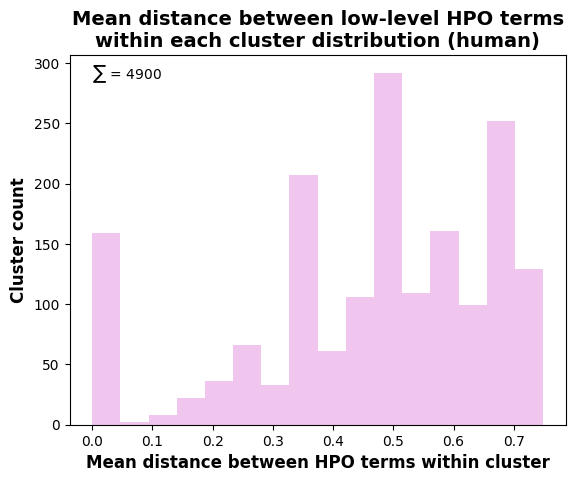

In [107]:
sns.distplot(
    np.array(distance_means_h)[:, 1],
    color="orchid",
    kde=False
)

plt.xlabel(
    "Mean distance between HPO terms within cluster",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="semibold"
)
plt.text(
    0, 300,
    s=fr"$\sum$ = {len(np.unique(cluster_labels_h))}",
    ha='left', va='top'
)

plt.title(
    "Mean distance between low-level HPO terms\nwithin each cluster distribution (human)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_31_HPO_distance_within_cluster_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

<a id="distances_within"><h4>Distance within clusters computation</h4></a>
[Back to content](#content)

In [158]:
# mouse
# np array with distance within cluster based on cluster label computation

distance_means_m_dict = dict(np.array(distance_means_m)[:, [0, 1]])
cluster_sizes_m_dict = dict(np.array(distance_means_m)[:, [0, 2]])
cluster_terms_m_dict = dict(np.array(distance_means_m)[:, [0, 3]])

cluster_distances_m = np.array([float(distance_means_m_dict[str(key)]) for key in cluster_labels_m])
cluster_sizes_m = np.array([int(cluster_sizes_m_dict[str(key)]) for key in cluster_labels_m])
cluster_terms_m = np.array([cluster_terms_m_dict[str(key)] for key in cluster_labels_m])

# df with all MPO low-level terms, cluster labels and within cluster distances

clustered_mps = pd.concat([
    pd.DataFrame(coordinates_m).rename(columns={0: "x", 1: "y"}), 
    pd.DataFrame(cluster_labels_m).rename(columns={0: "cluster_label"}), 
    pd.DataFrame(cluster_distances_m).rename(columns={0: "distance_within_cluster"}),
    pd.DataFrame(cluster_sizes_m).rename(columns={0: "cluster_size"}),
    pd.DataFrame(cluster_terms_m).rename(columns={0: "cluster_terms"})
], axis=1)

clustered_mps.to_csv(
    "../intermediate_data/clustered_mps_label_distance.csv"
)

In [166]:
# human
# np array with distance within cluster based on cluster label computation

distance_means_h_dict = dict(np.array(distance_means_h)[:, [0, 1]])
cluster_sizes_h_dict = dict(np.array(distance_means_h)[:, [0, 2]])
cluster_terms_h_dict = dict(np.array(distance_means_h)[:, [0, 3]])

cluster_distances_h = np.array([float(distance_means_h_dict[str(key)]) for key in cluster_labels_h])
cluster_sizes_h = np.array([int(cluster_sizes_h_dict[str(key)]) for key in cluster_labels_h])
cluster_terms_h = np.array([cluster_terms_h_dict[str(key)] for key in cluster_labels_h])

# df with all MPO low-level terms, cluster labels and within cluster distances

clustered_hps = pd.concat([
    pd.DataFrame(coordinates_h).rename(columns={0: "x", 1: "y"}), 
    pd.DataFrame(cluster_labels_h).rename(columns={0: "cluster_label"}), 
    pd.DataFrame(cluster_distances_h).rename(columns={0: "distance_within_cluster"}),
    pd.DataFrame(cluster_sizes_h).rename(columns={0: "cluster_size"}),
    pd.DataFrame(cluster_terms_h).rename(columns={0: "cluster_terms"})
], axis=1)

clustered_hps.to_csv(
    "../intermediate_data/clustered_hps_label_distance.csv"
)

In [167]:
clustered_mps.sort_values(by="distance_within_cluster")

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms
7645,-0.000004,0.000110,2816,0.0,2,"MP:0008819,MP:0030098"
504,0.000044,-0.000087,3071,0.0,2,"MP:0031291,MP:0003757"
3670,0.000106,-0.000011,2081,0.0,2,"MP:0031185,MP:0012011"
8550,0.000056,-0.000180,5074,0.0,3,"MP:0013798,MP:0000481,MP:0013796"
3897,-0.000123,-0.000021,5505,0.0,2,"MP:0013468,MP:0003483"
...,...,...,...,...,...,...
10604,0.000078,0.000569,1702,NaN,1,MP:0014178
10606,-0.002841,-0.002010,2141,NaN,1,MP:0008432
10615,-0.000046,0.000191,1784,NaN,1,MP:0002917
10616,0.000049,0.000037,1863,NaN,1,MP:0004637


<a id="visualization"><h4>Visualization</h4></a>
[Back to content](#content)

In [39]:
best_n_clusters_m, best_n_clusters_h = 5936, 4900

In [40]:
clustered_mps = pd.read_csv(
    "../intermediate_data/clustered_mps_label_distance.csv",
    index_col=0
)
clustered_mps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms
0,0.000398,-0.000433,5488,NaN,1,MP:0004175
1,-0.005375,-0.003482,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449"
2,-0.000219,0.000102,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866"
3,0.004489,0.002894,2066,0.805195,2,"MP:0001176,MP:0006027"
4,-0.000162,0.000273,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP..."


In [41]:
def color_set_m(x):
    if 0 <= x < 0.5:
        return "mediumturquoise"    
    elif 0.5 <= x <= 0.65:
        return "fuchsia"
    elif 0.65 < x <= 1:
        return "navy"
    else:
        return "black"

In [42]:
clustered_mps["color"] = clustered_mps\
    .distance_within_cluster\
    .apply(lambda x: color_set_m(x) if not isnan(x) else x)

clustered_mps.sort_values(by="distance_within_cluster", ascending=False)

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms,color
4213,0.000122,0.000067,12,0.833333,2,"MP:0013178,MP:0003466",navy
6492,-0.000547,0.004373,0,0.833333,2,"MP:0009006,MP:0009017",navy
1891,0.001561,-0.002406,0,0.833333,2,"MP:0009006,MP:0009017",navy
791,-0.000004,0.000019,2,0.833333,2,"MP:0008363,MP:0006412",navy
8,0.000010,0.000022,2,0.833333,2,"MP:0008363,MP:0006412",navy
...,...,...,...,...,...,...,...
10604,0.000078,0.000569,1702,NaN,1,MP:0014178,NaN
10606,-0.002841,-0.002010,2141,NaN,1,MP:0008432,NaN
10615,-0.000046,0.000191,1784,NaN,1,MP:0002917,NaN
10616,0.000049,0.000037,1863,NaN,1,MP:0004637,NaN


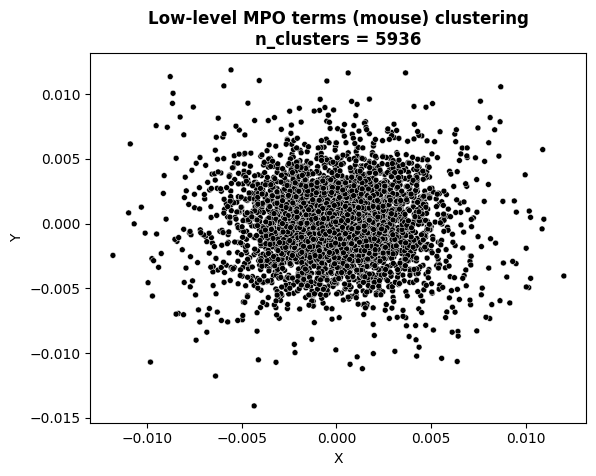

In [9]:
# plotting (mouse), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_m = np.array(clustered_mps.color.tolist())
mouse_colors = np.where(cols_m == "nan", "black", cols_m)
mouse_sizes = clustered_mps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_mps,
    x="x",
    y="y",
    color="k",
    size=3,
    legend=False
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_32_mouse_clustered",
    bbox_inches="tight",
    dpi=800
)

plt.show()

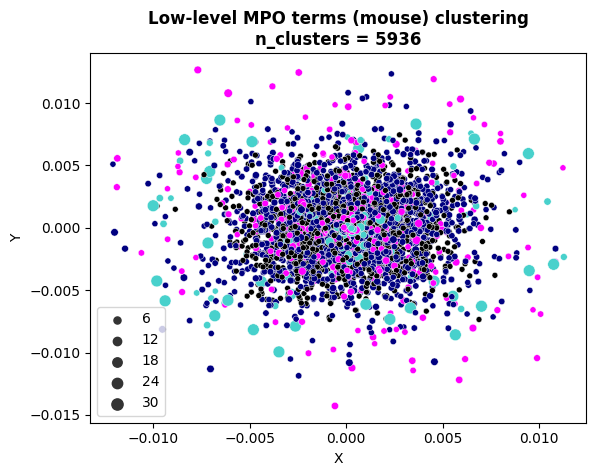

In [45]:
# plotting (mouse), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_m = np.array(clustered_mps.color.tolist())
mouse_colors = np.where(cols_m == "nan", "black", cols_m)
mouse_sizes = clustered_mps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_mps,
    x="x",
    y="y",
    color=mouse_colors,
    size=mouse_sizes,
    legend=True
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_34_mouse_clustered_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [46]:
print(clustered_mps.shape)
print(len(mouse_colors))

clustered_mps.head()

(10632, 7)
10632


,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms,color
0,0.000398,-0.000433,5488,NaN,1,MP:0004175,NaN
1,-0.005375,-0.003482,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449",navy
2,-0.000219,0.000102,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866",fuchsia
3,0.004489,0.002894,2066,0.805195,2,"MP:0001176,MP:0006027",navy
4,-0.000162,0.000273,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP...",fuchsia


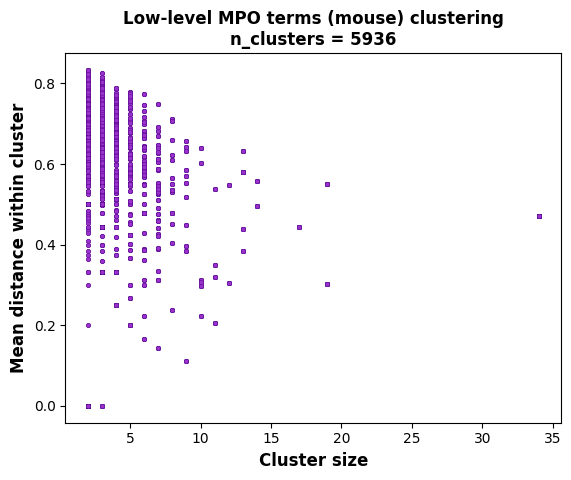

In [47]:
sns.scatterplot(
    data=clustered_mps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_36_mouse_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [48]:
clustered_hps = pd.read_csv(
    "../intermediate_data/clustered_hps_label_distance.csv",
    index_col=0
)
clustered_hps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms
0,-0.000745,0.002315,211,0.505693,10,"HP:0000190,HP:0011802,HP:0006145,HP:0007036,HP..."
1,0.001994,0.000175,608,0.313939,11,"HP:0005793,HP:0012294,HP:0012809,HP:0030816,HP..."
2,-0.000104,0.000068,518,0.552778,4,"HP:0045028,HP:0003808,HP:0006818,HP:0006270"
3,0.000293,-0.000163,2531,NaN,1,HP:0001115
4,0.001552,-0.000508,92,0.537007,5,"HP:0012330,HP:0006557,HP:0011760,HP:0012592,HP..."


In [49]:
def color_set_h(x):
    if 0 <= x < 0.3:
        return "mediumturquoise"    
    elif 0.3 <= x <= 0.5:
        return "fuchsia"
    elif 0.5 < x <= 1:
        return "navy"
    else:
        return "black"

In [50]:
clustered_hps["color"] = clustered_hps\
    .distance_within_cluster\
    .apply(lambda x: color_set_h(x) if not isnan(x) else x)

In [51]:
clustered_mps.sort_values(by="distance_within_cluster", ascending=False)

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms,color
4213,0.000122,0.000067,12,0.833333,2,"MP:0013178,MP:0003466",navy
6492,-0.000547,0.004373,0,0.833333,2,"MP:0009006,MP:0009017",navy
1891,0.001561,-0.002406,0,0.833333,2,"MP:0009006,MP:0009017",navy
791,-0.000004,0.000019,2,0.833333,2,"MP:0008363,MP:0006412",navy
8,0.000010,0.000022,2,0.833333,2,"MP:0008363,MP:0006412",navy
...,...,...,...,...,...,...,...
10604,0.000078,0.000569,1702,NaN,1,MP:0014178,NaN
10606,-0.002841,-0.002010,2141,NaN,1,MP:0008432,NaN
10615,-0.000046,0.000191,1784,NaN,1,MP:0002917,NaN
10616,0.000049,0.000037,1863,NaN,1,MP:0004637,NaN


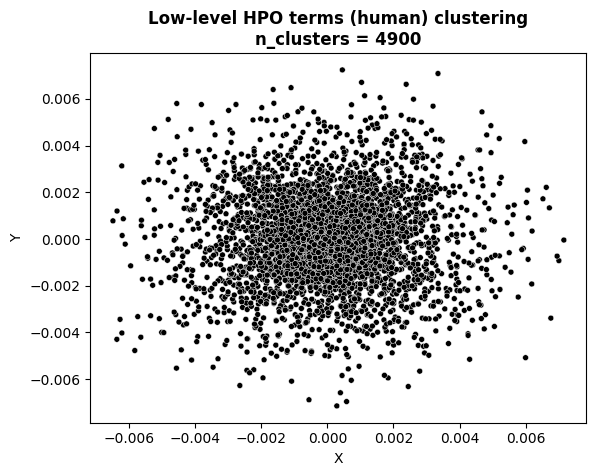

In [52]:
# plotting (human), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_h = np.array(clustered_hps.color.tolist())
human_colors = np.where(cols_h == "nan", "black", cols_h)
human_sizes = clustered_hps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_hps,
    x="x",
    y="y",
    color="k",
    size=3,
    legend=False
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_33_human_clustered",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [53]:
# plotting (human), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_h = np.array(clustered_hps.color.tolist())
human_colors = np.where(cols_h == "nan", "black", cols_h)
human_sizes = clustered_hps.import os
from ontobio.ontol_factory import OntologyFactorycluster_size.tolist()

sns.scatterplot(
    data=clustered_hps,
    x="x",
    y="y",
    color=human_colors,
    size=human_sizes,
    legend=True
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_35_human_clustered_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

SyntaxError: invalid syntax (250974999.py, line 7)

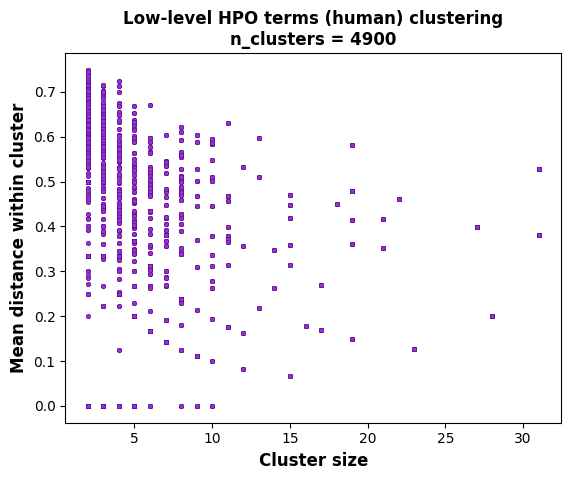

In [ ]:
sns.scatterplot(
    data=clustered_hps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_37_human_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

/tmp/ipykernel_5880/1211887098.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_5880/1211887098.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_5880/1211887098.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.

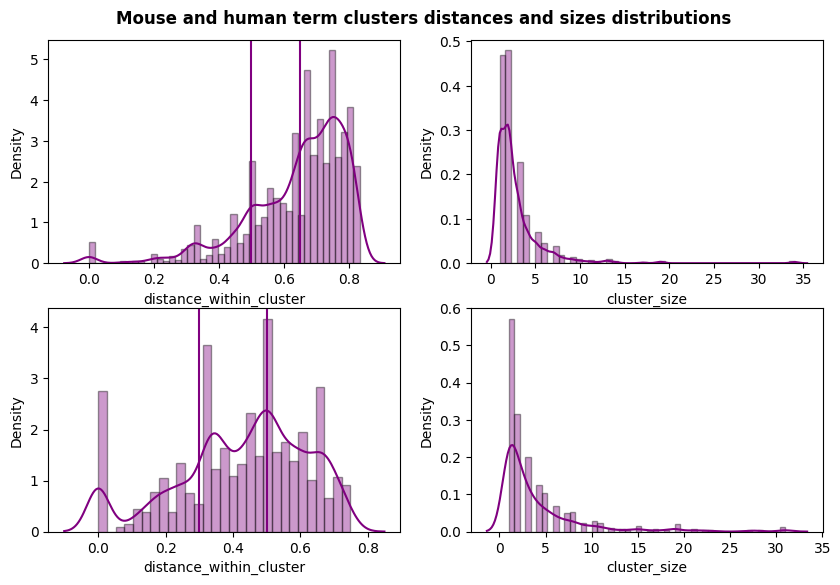

In [54]:
plt.figure(figsize=(10, 6))

dist_set = {
    "color": "purple",
    "hist_kws": {"edgecolor": "black"}
}

plt.subplot(2, 2, 2)

sns.distplot(
    clustered_mps.cluster_size,
    **dist_set
)

plt.subplot(2, 2, 1)

sns.distplot(
    clustered_mps.distance_within_cluster,
    **dist_set
)

plt.axvline(
    x=0.5,
    c="purple"
)
plt.axvline(
    x=0.65,
    c="purple"
)

plt.subplot(2, 2, 4)

sns.distplot(
    clustered_hps.cluster_size,
    **dist_set
)

plt.subplot(2, 2, 3)

sns.distplot(
    clustered_hps.distance_within_cluster,
    **dist_set
)

plt.axvline(
    x=0.3,
    c="purple"
)
plt.axvline(
    x=0.5,
    c="purple"
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "Mouse and human term clusters distances and sizes distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_38_human_mouse_cluster_parameters",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [ ]:
sns.scatterplot(
    data=clustered_hps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_37_human_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

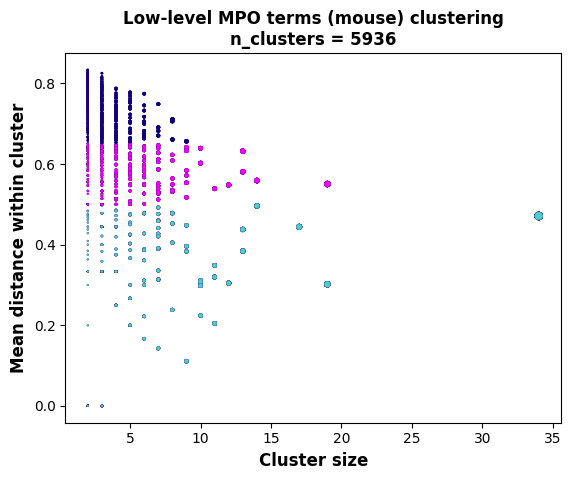

In [55]:
clustered_mps["color"] = clustered_mps.color.fillna("black")

sns.scatterplot(
    data=clustered_mps[~clustered_mps.distance_within_cluster.isna()],
    x="cluster_size",
    y="distance_within_cluster",
    s=clustered_mps[~clustered_mps.distance_within_cluster.isna()].cluster_size.tolist(), 
    color=clustered_mps[~clustered_mps.distance_within_cluster.isna()].color.tolist(),
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_39_mouse_custer_size_distance_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

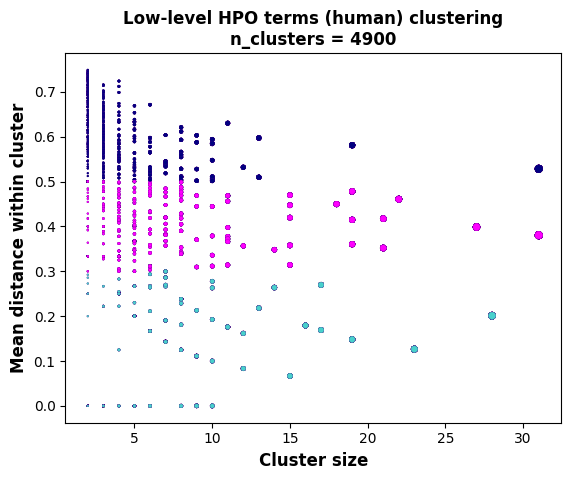

In [56]:
clustered_hps["color"] = clustered_hps.color.fillna("black")

sns.scatterplot(
    data=clustered_hps[~clustered_hps.distance_within_cluster.isna()],
    x="cluster_size",
    y="distance_within_cluster",
    s=clustered_hps[~clustered_hps.distance_within_cluster.isna()].cluster_size.tolist(), 
    color=clustered_hps[~clustered_hps.distance_within_cluster.isna()].color.tolist(),
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_40_human_custer_size_distance_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

Adding information to clusters: root distance, leaf distance, system term (if possible)

<a id="label"><h4>Distance between each low-level terms pair distribution</h4></a>
[Back to content](#content)

Clustering recheck

In [57]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from ontobio.ontol_factory import OntologyFactory

In [58]:
hpo = OntologyFactory().create(handle=PATH_HPO)
mpo = OntologyFactory().create(handle=PATH_MPO)

In [59]:
clustered_mps = pd.read_csv(
    "../intermediate_data/clustered_mps_label_distance.csv",
    index_col=0
)
clustered_mps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms
0,0.000398,-0.000433,5488,NaN,1,MP:0004175
1,-0.005375,-0.003482,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449"
2,-0.000219,0.000102,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866"
3,0.004489,0.002894,2066,0.805195,2,"MP:0001176,MP:0006027"
4,-0.000162,0.000273,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP..."


In [60]:
clustered_hps = pd.read_csv(
    "../intermediate_data/clustered_hps_label_distance.csv",
    index_col=0
)
clustered_hps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms
0,-0.000745,0.002315,211,0.505693,10,"HP:0000190,HP:0011802,HP:0006145,HP:0007036,HP..."
1,0.001994,0.000175,608,0.313939,11,"HP:0005793,HP:0012294,HP:0012809,HP:0030816,HP..."
2,-0.000104,0.000068,518,0.552778,4,"HP:0045028,HP:0003808,HP:0006818,HP:0006270"
3,0.000293,-0.000163,2531,NaN,1,HP:0001115
4,0.001552,-0.000508,92,0.537007,5,"HP:0012330,HP:0006557,HP:0011760,HP:0012592,HP..."


In [61]:
def extract_common_ancestor(ancestors):
    """
    Takes list of lists or list of sets
    of ancestors for each term
    Returns set of common ancestor
    present in each set of anceestors
    """
    ancestors = list(map(set, ancestors)) # make ancestors of each term list of sets
    return set.intersection(*ancestors)

In [62]:
def find_root_distance(term, ontology_type):
    """
    Function to compute the distance from root of a term
    Takes term (str) and ontology_type (str, "mpo" or "hpo")
    Returns int dostance of the term from root
    """
    if ontology_type == "mpo":
        ont = mpo
        root = 'MP:0000001'
    elif ontology_type == "hpo":
        ont = hpo
        root = 'HP:0000001'
    else:
        return None
    
    ancestors = set([term])
    root_distance = 0
    while root not in ancestors:
        root_distance += 1
        ancestors_n = []
        for ancestor in ancestors:
            ancestors_n.extend(ont.parents(ancestor))
        ancestors = set(ancestors_n)
    
    return root_distance

In [63]:
def find_common_ancestors(terms, ontology_type):
    """
    Function to find closest common ancestor of all terms given
    Takes terms (string of comma without space separated terms)
    and ontology type (mpo or hpo, string)
    Returns tuple of closest common ancestors list(could theoretically be more than one),
    Max distance from leaf to common ancestor
    Distance from root to nearest common ancestor
    """
    
    if ontology_type == "mpo":
        ont = mpo
    elif ontology_type == "hpo":
        ont = hpo
    else:
        return None
    
    ancestors = []
    for term in terms.split(","):
        ancestors.append([term] + ont.parents(term))

    max_leaf_distance = 1
    while extract_common_ancestor(ancestors) == set():
        max_leaf_distance += 1
        for ancestor_list in ancestors:
            ancestor_list_ext = list()
            for ancestor in ancestor_list:
                new_ancestors = ont.parents(ancestor)
                ancestor_list_ext.extend(new_ancestors)
            ancestor_list.extend(ancestor_list_ext)
    
    common_ancestors = list(extract_common_ancestor(ancestors))
    root_distance = list(map(lambda t: find_root_distance(t, ontology_type=ontology_type), common_ancestors))
    
    return (",".join(common_ancestors), max_leaf_distance, root_distance)

In [255]:
clustered_mps = clustered_mps.drop(columns=["x", "y"]).drop_duplicates(subset="cluster_label")
clustered_hps = clustered_hps.drop(columns=["x", "y"]).drop_duplicates(subset="cluster_label")

clustered_mps["position"] = clustered_mps.cluster_terms.apply(lambda t: find_common_ancestors(t, ontology_type="mpo"))

clustered_hps["position"] = clustered_hps.cluster_terms.apply(lambda t: find_common_ancestors(t, ontology_type="hpo"))


clustered_mps["root_distance"] = clustered_mps.position.apply(lambda x: x[-1])

clustered_hps["root_distance"] = clustered_hps.position.apply(lambda x: x[-1])

clustered_mps["max_term_distance"] = clustered_mps.position.apply(lambda x: x[1])
clustered_hps["max_term_distance"] = clustered_hps.position.apply(lambda x: x[1])


clustered_mps_distance_1 = clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x) == 1)]

clustered_hps_distance_1 = clustered_hps[clustered_hps.root_distance.apply(lambda x: len(x) == 1)]


clustered_mps_distance_1["root_distance_int"] = clustered_mps_distance_1.root_distance.apply(lambda x: int(x[0]))

clustered_hps_distance_1["root_distance_int"] = clustered_hps_distance_1.root_distance.apply(lambda x: int(x[0]))

/tmp/ipykernel_5880/1818034605.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_mps_distance_1["root_distance_int"] = clustered_mps_distance_1.root_distance.apply(lambda x: int(x[0]))
/tmp/ipykernel_5880/1818034605.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clustered_hps_distance_1["root_distance_int"] = clustered_hps_distance_1.root_distance.apply(lambda x: int(x[0]))


How many MPO and HPO clusters have common ancestors?

In [115]:
mp_clusters_by_size = pd.DataFrame(clustered_mps.cluster_size.value_counts())\
    .reset_index().rename(columns={"count": "cluster_count"})
hp_clusters_by_size = pd.DataFrame(clustered_hps.cluster_size.value_counts())\
    .reset_index().rename(columns={"count": "cluster_count"})

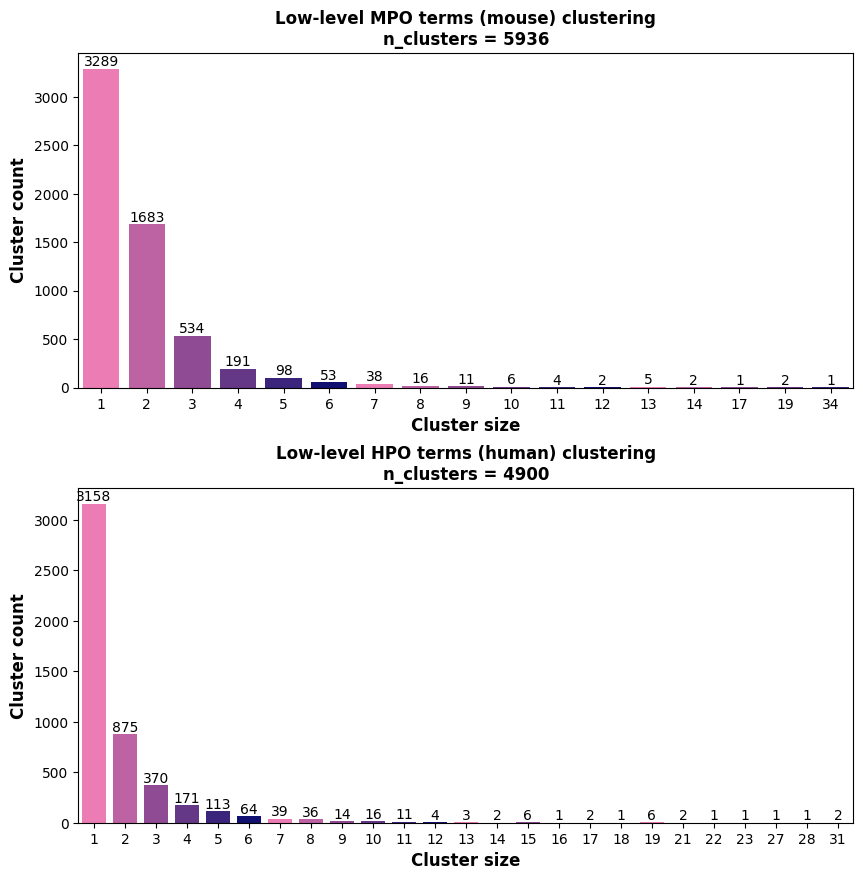

In [175]:
plt.figure(figsize=(10, 10))

plt.subplot(2, 1, 1)

ax = sns.barplot(
    data=mp_clusters_by_size,
    y="cluster_count",
    x="cluster_size",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.subplot(2, 1, 2)

ax = sns.barplot(
    data=hp_clusters_by_size,
    y="cluster_count",
    x="cluster_size",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.subplots_adjust(hspace=0.3)

plt.savefig(
    f"{PLOTS_DIR}/concord_41_mouse_human_custer_size_count",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [188]:
mpo_counts = pd.DataFrame(clustered_mps.root_distance.apply(lambda x: len(x)).value_counts())\
    .reset_index().rename(columns={"count": "clusters", "root_distance": "ancestor_count"})
hpo_counts = pd.DataFrame(clustered_hps.root_distance.apply(lambda x: len(x)).value_counts())\
    .reset_index().rename(columns={"count": "clusters", "root_distance": "ancestor_count"})

In [274]:
mpo_counts

,ancestor_count,clusters
0,2,2561
1,1,2535
2,3,783
3,4,56
4,5,1


In [190]:
hpo_counts

,ancestor_count,clusters
0,2,2628
1,1,1697
2,3,525
3,4,44
4,5,5
5,6,1


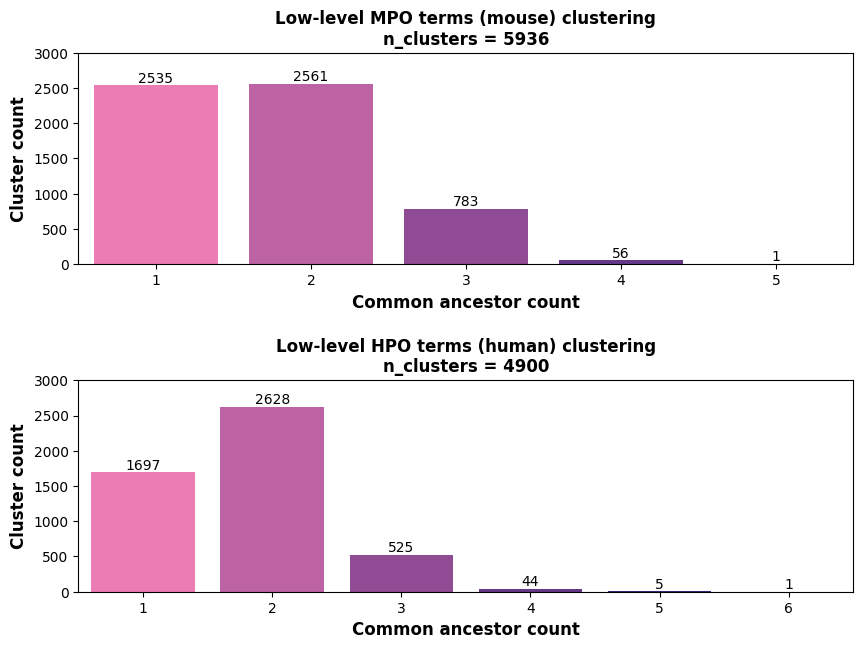

In [191]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)

ax = sns.barplot(
    data=mpo_counts,
    y="clusters",
    x="ancestor_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Common ancestor count",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="bold"
)
plt.ylim(0, 3000)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.subplot(2, 1, 2)

ax = sns.barplot(
    data=hpo_counts,
    y="clusters",
    x="ancestor_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Common ancestor count",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="bold"
)
plt.ylim(0, 3000)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.subplots_adjust(hspace=0.55)

plt.savefig(
    f"{PLOTS_DIR}/concord_42_mouse_human_ancestor_count",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [197]:
clustered_mps[clustered_mps.cluster_size == 1].root_distance.apply(lambda x: len(x)).value_counts()

root_distance
2    2451
3     781
4      56
5       1
Name: count, dtype: int64

In [198]:
clustered_hps[clustered_hps.cluster_size == 1].root_distance.apply(lambda x: len(x)).value_counts()

root_distance
2    2591
3     518
4      43
5       5
6       1
Name: count, dtype: int64

In [201]:
import itertools

In [224]:
mps_root_dist_all = list(itertools.chain(*clustered_mps.root_distance.tolist()))
hps_root_dist_all = list(itertools.chain(*clustered_hps.root_distance.tolist()))

mps_root_dist_all_frame = pd.DataFrame(pd.Series(mps_root_dist_all).value_counts())\
    .reset_index().rename(columns={"index": "root_distance", "count": "distance_count"})
hps_root_dist_all_frame = pd.DataFrame(pd.Series(hps_root_dist_all).value_counts())\
    .reset_index().rename(columns={"index": "root_distance", "count": "distance_count"})

<Axes: ylabel='Count'>

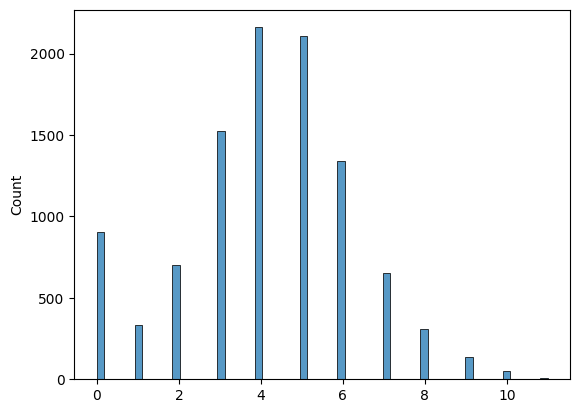

In [205]:
sns.histplot(mps_root_dist_all)

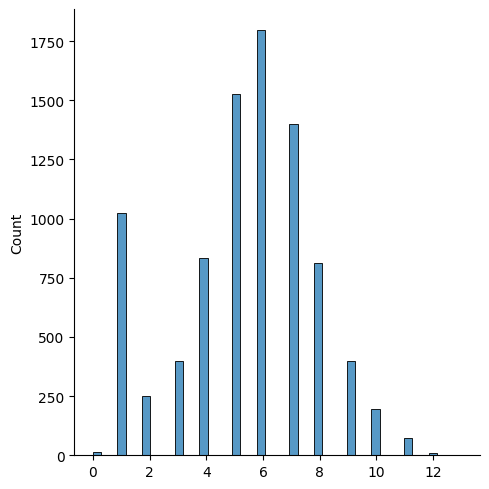

In [212]:
sns.histplot(hps_root_dist_all)

In [225]:
mps_root_dist_all_frame

,root_distance,distance_count
0,4,2162
1,5,2107
2,3,1524
3,6,1342
4,0,906
5,2,701
6,7,655
7,1,331
8,8,311
9,9,138


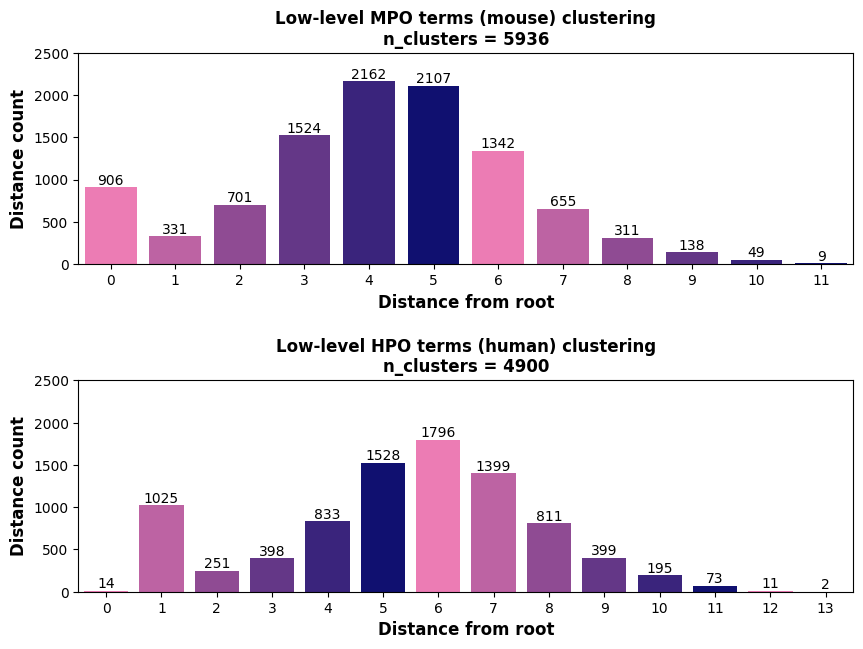

In [246]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)

ax = sns.barplot(
    data=mps_root_dist_all_frame,
    x="root_distance",
    y="distance_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Distance from root",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Distance count",
    size=12,
    weight="bold"
)
plt.ylim(0, 2500)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.subplot(2, 1, 2)

ax = sns.barplot(
    data=hps_root_dist_all_frame,
    x="root_distance",
    y="distance_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Distance from root",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Distance count",
    size=12,
    weight="bold"
)
plt.ylim(0, 2500)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.subplots_adjust(hspace=0.55)

plt.savefig(
    f"{PLOTS_DIR}/concord_43_mouse_human_root_dist_all_count",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [243]:
mps_root_dist_single = clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1]\
    .root_distance.apply(lambda x: x[0]).tolist()
hps_root_dist_single = clustered_hps[clustered_hps.root_distance.apply(lambda x: len(x)) == 1]\
    .root_distance.apply(lambda x: x[0]).tolist()

mps_root_dist_single_frame = pd.DataFrame(pd.Series(mps_root_dist_single).value_counts())\
    .reset_index().rename(columns={"index": "root_distance", "count": "distance_count"})
hps_root_dist_single_frame = pd.DataFrame(pd.Series(hps_root_dist_single).value_counts())\
    .reset_index().rename(columns={"index": "root_distance", "count": "distance_count"})

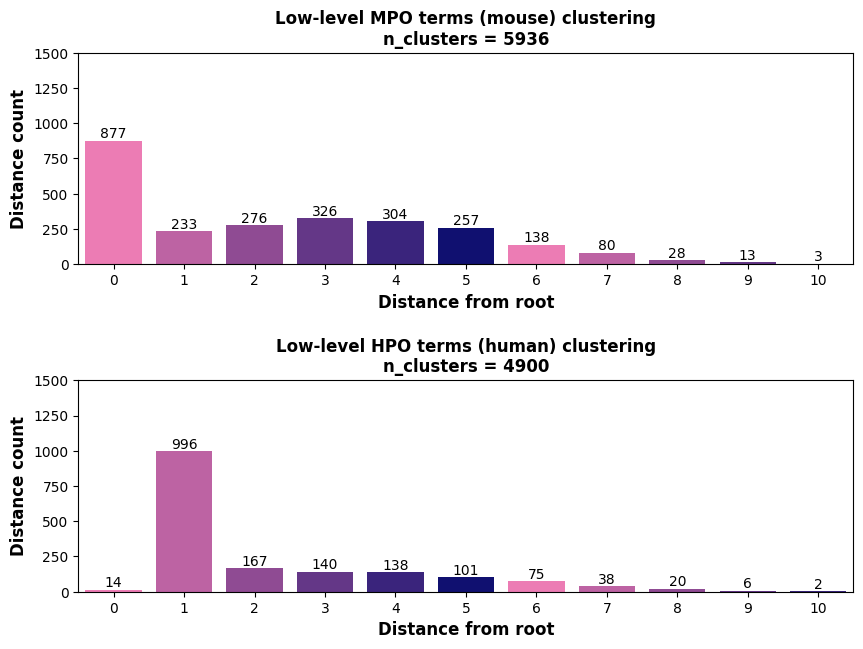

In [245]:
plt.figure(figsize=(10, 7))

plt.subplot(2, 1, 1)

ax = sns.barplot(
    data=mps_root_dist_single_frame,
    x="root_distance",
    y="distance_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Distance from root",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Distance count",
    size=12,
    weight="bold"
)
plt.ylim(0, 1500)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.subplot(2, 1, 2)

ax = sns.barplot(
    data=hps_root_dist_single_frame,
    x="root_distance",
    y="distance_count",
    palette=sns.blend_palette(["hotpink", "navy"])
)
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.xlabel(
    "Distance from root",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Distance count",
    size=12,
    weight="bold"
)
plt.ylim(0, 1500)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.subplots_adjust(hspace=0.55)

plt.savefig(
    f"{PLOTS_DIR}/concord_44_mouse_human_root_dist_single_ancestor_count",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [261]:
counts = clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].groupby([clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].root_distance.apply(lambda x: x[0]).tolist(), 
                       clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].max_term_distance.tolist()]).size().reset_index(name='counts')

sns.scatterplot(
    x=clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].root_distance.apply(lambda x: x[0]).tolist(),
    y=clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].max_term_distance,
    size="counts"
)

ValueError: Could not interpret value `counts` for parameter `size`

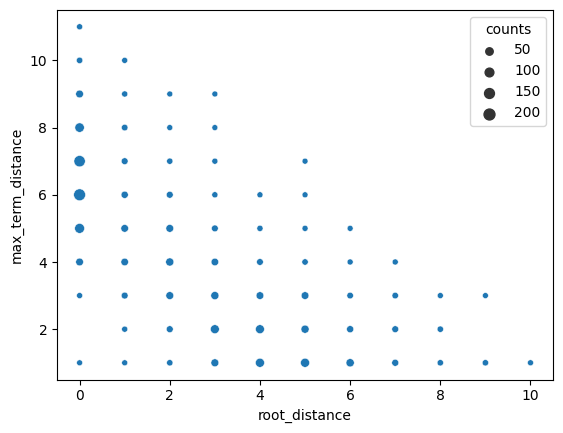

In [266]:
data = pd.DataFrame({'root_distance': clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].root_distance.apply(lambda x: x[0]).tolist(),
                     'max_term_distance': clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1].max_term_distance.tolist()})

counts = data.groupby(['root_distance', 'max_term_distance']).size().reset_index(name='counts')

sns.scatterplot(x='root_distance', y='max_term_distance', size='counts', data=counts)


plt.savefig(
    f"{PLOTS_DIR}/concord_45_mouse_root_vs_term_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

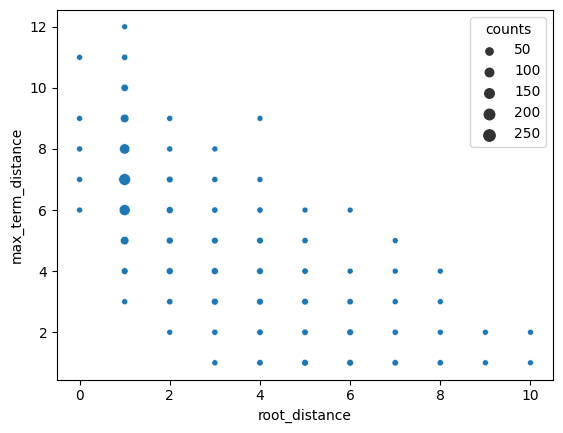

In [267]:
data = pd.DataFrame({'root_distance': clustered_hps[clustered_hps.root_distance.apply(lambda x: len(x)) == 1].root_distance.apply(lambda x: x[0]).tolist(),
                     'max_term_distance': clustered_hps[clustered_hps.root_distance.apply(lambda x: len(x)) == 1].max_term_distance.tolist()})

counts = data.groupby(['root_distance', 'max_term_distance']).size().reset_index(name='counts')

sns.scatterplot(x='root_distance', y='max_term_distance', size='counts', data=counts)


plt.savefig(
    f"{PLOTS_DIR}/concord_46_human_root_vs_term_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [273]:
clustered_mps

,cluster_label,distance_within_cluster,cluster_size,cluster_terms,position,root_distance,max_term_distance
0,5488,NaN,1,MP:0004175,"(MP:0001613,MP:0004175, 1, [4, 5])","[4, 5]",1
1,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449","(MP:0000428, 6, [2])",[2],6
2,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866","(MP:0000001, 9, [0])",[0],9
3,2066,0.805195,2,"MP:0001176,MP:0006027","(MP:0001176, 2, [4])",[4],2
4,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP...","(MP:0000001, 8, [0])",[0],8
...,...,...,...,...,...,...,...
10604,1702,NaN,1,MP:0014178,"(MP:0003633,MP:0006042,MP:0014178, 1, [2, 5, 3])","[2, 5, 3]",1
10606,2141,NaN,1,MP:0008432,"(MP:0008414,MP:0008432, 1, [5, 6])","[5, 6]",1
10615,1784,NaN,1,MP:0002917,"(MP:0002917,MP:0002915, 1, [7, 6])","[7, 6]",1
10616,1863,NaN,1,MP:0004637,"(MP:0004637,MP:0003073, 1, [6, 5])","[6, 5]",1


In [271]:
for term in hpo.children("HP:0000001"):
    print(term, hpo.label(term))

HP:0000005 Mode of inheritance
HP:0000118 Phenotypic abnormality
HP:0012823 Clinical modifier
HP:0032223 Blood group
HP:0032443 Past medical history
HP:0040279 Frequency


In [272]:
for term in mpo.children("MP:0000001"):
    print(term, mpo.label(term))

MP:0001186 pigmentation phenotype
MP:0002006 neoplasm
MP:0002873 normal phenotype
MP:0003012 no phenotypic analysis
MP:0003631 nervous system phenotype
MP:0005367 renal/urinary system phenotype
MP:0005369 muscle phenotype
MP:0005370 liver/biliary system phenotype
MP:0005371 limbs/digits/tail phenotype
MP:0005375 adipose tissue phenotype
MP:0005376 homeostasis/metabolism phenotype
MP:0005377 hearing/vestibular/ear phenotype
MP:0005378 growth/size/body region phenotype
MP:0005379 endocrine/exocrine gland phenotype
MP:0005380 embryo phenotype
MP:0005381 digestive/alimentary phenotype
MP:0005382 craniofacial phenotype
MP:0005384 cellular phenotype
MP:0005385 cardiovascular system phenotype
MP:0005386 behavior/neurological phenotype
MP:0005387 immune system phenotype
MP:0005388 respiratory system phenotype
MP:0005389 reproductive system phenotype
MP:0005390 skeleton phenotype
MP:0005391 vision/eye phenotype
MP:0005394 taste/olfaction phenotype
MP:0005397 hematopoietic system phenotype
MP:00

In [268]:
clustered_mps

,cluster_label,distance_within_cluster,cluster_size,cluster_terms,position,root_distance,max_term_distance
0,5488,NaN,1,MP:0004175,"(MP:0001613,MP:0004175, 1, [4, 5])","[4, 5]",1
1,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449","(MP:0000428, 6, [2])",[2],6
2,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866","(MP:0000001, 9, [0])",[0],9
3,2066,0.805195,2,"MP:0001176,MP:0006027","(MP:0001176, 2, [4])",[4],2
4,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP...","(MP:0000001, 8, [0])",[0],8
...,...,...,...,...,...,...,...
10604,1702,NaN,1,MP:0014178,"(MP:0003633,MP:0006042,MP:0014178, 1, [2, 5, 3])","[2, 5, 3]",1
10606,2141,NaN,1,MP:0008432,"(MP:0008414,MP:0008432, 1, [5, 6])","[5, 6]",1
10615,1784,NaN,1,MP:0002917,"(MP:0002917,MP:0002915, 1, [7, 6])","[7, 6]",1
10616,1863,NaN,1,MP:0004637,"(MP:0004637,MP:0003073, 1, [6, 5])","[6, 5]",1


In [258]:
clustered_mps[clustered_mps.root_distance.apply(lambda x: len(x)) == 1]

,cluster_label,distance_within_cluster,cluster_size,cluster_terms,position,root_distance,max_term_distance
1,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449","(MP:0000428, 6, [2])",[2],6
2,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866","(MP:0000001, 9, [0])",[0],9
3,2066,0.805195,2,"MP:0001176,MP:0006027","(MP:0001176, 2, [4])",[4],2
4,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP...","(MP:0000001, 8, [0])",[0],8
5,140,0.823529,2,"MP:0003197,MP:0006133","(MP:0000001, 5, [0])",[0],5
...,...,...,...,...,...,...,...
10223,73,0.828571,2,"MP:0011699,MP:0011698","(MP:0011698, 1, [3])",[3],1
10282,1343,0.000000,2,"MP:0030195,MP:0030368","(MP:0000428, 4, [2])",[2],4
10325,5425,0.600000,2,"MP:0006095,MP:0002983","(MP:0000965, 3, [4])",[4],3
10387,1817,0.761905,2,"MP:0010537,MP:0000423","(MP:0000001, 4, [0])",[0],4


In [ ]:
clustered_mps_distance_1.root_distance_int.value_counts()

root_distance_int
0     3062
3      786
4      734
2      699
1      601
5      586
6      320
7      178
8       64
9       31
10       6
Name: count, dtype: int64

In [ ]:
clustered_hps_distance_1.root_distance_int.value_counts()

root_distance_int
1     4052
2      533
4      363
3      343
5      232
6      166
7       91
0       50
8       42
9       13
10       4
Name: count, dtype: int64

In [ ]:
clustered_mps

<Axes: xlabel='root_distance_int', ylabel='Count'>

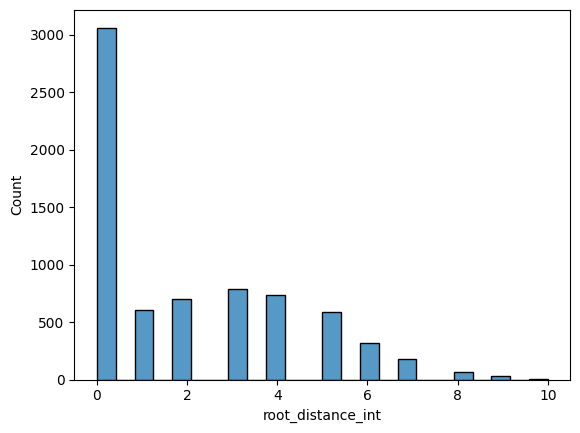

In [133]:
sns.histplot(clustered_mps_distance_1.root_distance_int)

In [113]:
clustered_mps[clustered_mps.position.apply(lambda x: len(x[-1])) == 1]

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms,position
1,-0.005375,-0.003482,380,0.725211,4,"MP:0030200,MP:0004448,MP:0031445,MP:0004449","(MP:0000428, 6, [2])"
2,-0.000219,0.000102,811,0.513889,4,"MP:0012304,MP:0003540,MP:0011172,MP:0010866","(MP:0000001, 9, [0])"
3,0.004489,0.002894,2066,0.805195,2,"MP:0001176,MP:0006027","(MP:0001176, 2, [4])"
4,-0.000162,0.000273,333,0.604762,7,"MP:0000021,MP:0013466,MP:0008890,MP:0010524,MP...","(MP:0000001, 8, [0])"
5,0.001115,-0.000695,140,0.823529,2,"MP:0003197,MP:0006133","(MP:0000001, 5, [0])"
...,...,...,...,...,...,...,...
10625,0.000074,0.000181,1935,0.384615,2,"MP:0010735,MP:0010734","(MP:0010734, 1, [6])"
10627,0.009205,0.002602,2321,0.571429,2,"MP:0002751,MP:0001034","(MP:0002751, 2, [3])"
10628,0.000302,0.000025,121,0.823529,2,"MP:0012515,MP:0004062","(MP:0000266, 3, [3])"
10630,0.000267,-0.000047,4254,0.333333,4,"MP:0012370,MP:0012372,MP:0008954,MP:0012365","(MP:0002447, 3, [5])"


In [114]:
clustered_mps[clustered_mps.position.apply(lambda x: len(x[-1])) != 1]

,x,y,cluster_label,distance_within_cluster,cluster_size,cluster_terms,position
0,0.000398,-0.000433,5488,NaN,1,MP:0004175,"(MP:0001613,MP:0004175, 1, [4, 5])"
6,-0.000025,0.000010,3385,NaN,1,MP:0004243,"(MP:0004243,MP:0010726, 1, [5, 4])"
8,0.000010,0.000022,2,0.833333,2,"MP:0008363,MP:0006412","(MP:0005387,MP:0005397, 9, [1, 1])"
15,0.001143,0.002347,4404,NaN,1,MP:0001380,"(MP:0001377,MP:0001380, 1, [5, 6])"
20,-0.000403,0.001254,4812,NaN,1,MP:0005094,"(MP:0000350,MP:0001828,MP:0005094, 1, [3, 7, 4])"
...,...,...,...,...,...,...,...
10606,-0.002841,-0.002010,2141,NaN,1,MP:0008432,"(MP:0008432,MP:0008414, 1, [6, 5])"
10615,-0.000046,0.000191,1784,NaN,1,MP:0002917,"(MP:0002917,MP:0002915, 1, [7, 6])"
10616,0.000049,0.000037,1863,NaN,1,MP:0004637,"(MP:0003073,MP:0004637, 1, [5, 6])"
10626,-0.001227,0.000377,2667,0.625000,2,"MP:0020355,MP:0020356","(MP:0005389,MP:0005379, 7, [1, 1])"


In [96]:
a = (1, 2, 3)
a[-1]

3

In [276]:
len(mpo.get_level(4))

3324

In [80]:
",".join(list(map(str, [1, 2, 3])))

'1,2,3'

In [84]:
find_common_ancestors("HP:0001574,HP:0000234", "hpo")

('HP:0000118', 2, [1])

In [85]:
find_common_ancestors("MP:0001399,MP:0003153", "mpo")

('MP:0000001', 5, [0])

In [52]:
anc = ['MP:0004449', 'MP:0030383', 'MP:0004451']

In [59]:
list(map(int, ["5", "4"]))

[5, 4]

In [60]:
list(map(lambda t: find_root_distance(t, ontology_type="mpo"), anc))

[8, 8, 9]

In [54]:
for i in anc:
    print(find_root_distance(i, "mpo"))

8
8
9


In [60]:
['MP:0030200'] + mpo.parents('MP:0030200')

['MP:0030200', 'MP:0002239', 'MP:0031449']

In [78]:
find_common_ancestors(terms='MP:0004449,MP:0030383,MP:0004451', ontology_type="mpo")

('MP:0004448', 2, [7])

In [77]:
find_common_ancestors(terms='MP:0030200,MP:0004448,MP:0031445,MP:0004449', ontology_type="mpo")

('MP:0000428', 6, [2])

In [66]:
mpo.parents("MP:0005382")

['MP:0000001']

In [75]:
mpo.children('MP:0004450')

[]

In [51]:
hpo.parents('HP:0000118')

['HP:0000001']

In [46]:
find_root_distance('HP:0000751', "hpo")

5

In [34]:
mpo.label('MP:0000013')

'abnormal adipose tissue distribution'

In [20]:
term = 'MP:0003736'
ancestors = set([term])
root_distance = 0
while 'MP:0000001' not in ancestors:
    root_distance += 1
    ancestors_n = []
    for ancestor in ancestors:
        ancestors_n.extend(mpo.parents(ancestor))
    print(ancestors_n, root_distance)
    ancestors = set(ancestors_n)

['MP:0000022'] 1
['MP:0002177'] 2
['MP:0000428', 'MP:0000432', 'MP:0002102'] 3
['MP:0005377', 'MP:0005382', 'MP:0005378'] 4
['MP:0000001', 'MP:0000001', 'MP:0000001'] 5


In [22]:
term = 'MP:0000001'
ancestors = set([term])
root_distance = 0
while 'MP:0000001' not in ancestors:
    root_distance += 1
    ancestors_n = []
    for ancestor in ancestors:
        ancestors_n.extend(mpo.parents(ancestor))
    print(ancestors_n, root_distance)
    ancestors = set(ancestors_n)
print(ancestors_n, root_distance)

['MP:0000001', 'MP:0000001', 'MP:0000001'] 0


In [18]:
mpo.children('MP:0000022')

['MP:0003735', 'MP:0003736']

In [ ]:
terms = set(['MP:0000428'])
counts = list()
for term in terms:
    count = 0
    if term != 'MP:0000001':
        

In [35]:
# function draft

terms = 'MP:0030200,MP:0004448,MP:0031445,MP:0004449'

parents = []
for term  in terms.split(","):
    parents.append(mpo.parents(term))
#print("parents", parents)
count = 1
while extract_common_ancestor(parents) == set():
    count += 1
    for parent_list in parents:
        #print("parent_list", parent_list)
        parent_list_ext = list()
        for parent in parent_list:
            #print("parent", parent)
            new_parents = mpo.parents(parent)
            #print("new_parents", new_parents)
            parent_list_ext.extend(new_parents)
        #print("extended", parent_list_ext)
        parent_list.extend(parent_list_ext)
print(count)
list(extract_common_ancestor(parents))

6


['MP:0000428']

In [24]:
for i in mpo.children('MP:0000001'):
    print(mpo.label(i))

pigmentation phenotype
neoplasm
normal phenotype
no phenotypic analysis
nervous system phenotype
renal/urinary system phenotype
muscle phenotype
liver/biliary system phenotype
limbs/digits/tail phenotype
adipose tissue phenotype
homeostasis/metabolism phenotype
hearing/vestibular/ear phenotype
growth/size/body region phenotype
endocrine/exocrine gland phenotype
embryo phenotype
digestive/alimentary phenotype
craniofacial phenotype
cellular phenotype
cardiovascular system phenotype
behavior/neurological phenotype
immune system phenotype
respiratory system phenotype
reproductive system phenotype
skeleton phenotype
vision/eye phenotype
taste/olfaction phenotype
hematopoietic system phenotype
mortality/aging
integument phenotype


In [18]:
terms = 'MP:0000452,MP:0002233,MP:0002240,MP:0002246'

parents = []
for term  in terms.split(","):
    parents.append(mpo.parents(term))
#print("parents", parents)
count = 1
while find_common_ancestor(parents) == set():
    count += 1
    for parent_list in parents:
        #print("parent_list", parent_list)
        parent_list_ext = list()
        for parent in parent_list:
            #print("parent", parent)
            new_parents = mpo.parents(parent)
            #print("new_parents", new_parents)
            parent_list_ext.extend(new_parents)
        #print("extended", parent_list_ext)
        parent_list.extend(parent_list_ext)
print(count)
list(find_common_ancestor(parents))

2


['MP:0003743']

In [17]:
mpo.children('MP:0002240')

['MP:0002245', 'MP:0002246', 'MP:0002247', 'MP:0002248', 'MP:0030382']

In [7]:
terms = 'MP:0002240,MP:0030031,MP:0000063,MP:0030531'

parents = []
for term  in terms.split(","):
    parents.append(mpo.parents(term))
#print("parents", parents)
while find_common_ancestor(parents) == set():
    for parent_list in parents:
        #print("parent_list", parent_list)
        parent_list_ext = list()
        for parent in parent_list:
            #print("parent", parent)
            new_parents = mpo.parents(parent)
            #print("new_parents", new_parents)
            parent_list_ext.extend(new_parents)
        #print("extended", parent_list_ext)
        parent_list.extend(parent_list_ext)

find_common_ancestor(parents)

{'MP:0000001'}

In [31]:
parents = []
for count, term  in enumerate('MP:0030200,MP:0004448,MP:0031445,MP:0004449'.split(",")):
    parents.append(mpo.parents(term))

set.intersection(*[set(pars) for pars in parents])

set()

In [28]:
[i for i in parents]

[['MP:0002239', 'MP:0031449'], ['MP:0000104'], ['MP:0005170'], ['MP:0004448']]

In [14]:
set.intersection(*[{1, 2, 3}, {3, 4}, {5, 3}])

{3}

In [21]:
set.intersection(*[{1, 2, }, {3, 4}, {5, 3}])

set()

In [20]:
list(map(set, [[3, 4], [5, 6], [6]]))

[{3, 4}, {5, 6}, {6}]

In [ ]:
terms = 'MP:0030200,MP:0004448,MP:0031445,MP:0004449'

In [7]:
for term  in 'MP:0030200,MP:0004448,MP:0031445,MP:0004449'.split(","):
    print(term, mpo.label(term), term in mpo.level)

MP:0030200 abnormal nasal septum cartilage morphology
MP:0004448 abnormal presphenoid bone morphology
MP:0031445 midline cleft upper lip
MP:0004449 absent presphenoid bone


In [12]:
mpo.get_level(15)

['MP:0030513',
 'MP:0030514',
 'MP:0030455',
 'MP:0030557',
 'MP:0030552',
 'MP:0030553',
 'MP:0030557',
 'MP:0009924',
 'MP:0009927',
 'MP:0010230']

In [27]:
find_common_ancestor([['MP:0002239', 'MP:0031449'], ['MP:0000104', 'MP:0031449'], ['MP:0005170', 'MP:0031449'], ['MP:0004448', 'MP:0031449']])

{'MP:0031449'}

In [9]:
dir(mpo)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_meta_element',
 '_contract_subset',
 '_get_basic_property_value',
 '_get_basic_property_values',
 '_get_meta',
 '_get_meta_prop',
 '_is_match',
 '_meta',
 'add_logical_definition',
 'add_node',
 'add_parent',
 'add_property_chain_axiom',
 'add_synonym',
 'add_text_definition',
 'add_to_subset',
 'add_xref',
 'all_logical_definitions',
 'all_obsoletes',
 'all_property_chain_axioms',
 'all_synonyms',
 'ancestors',
 'child_parent_relations',
 'children',
 'create_slim_mapping',
 'descendants',
 'equiv_graph',
 'extract_subset',
 'filter_redundant',
 'get_filtered_graph',
 'get_graph',
 'get_level',
 'get_node_type',
 '

In [66]:
terms = 'MP:0030200,MP:0004448,MP:0031445,MP:0004449'

parents = []
for term  in terms.split(","):
    parents.append(mpo.parents(term))
#print("parents", parents)
while find_common_ancestor(parents) == set():
    for parent_list in parents:
        #print("parent_list", parent_list)
        parent_list_ext = list()
        for parent in parent_list:
            #print("parent", parent)
            new_parents = mpo.parents(parent)
            #print("new_parents", new_parents)
            parent_list_ext.extend(new_parents)
        #print("extended", parent_list_ext)
        parent_list.extend(parent_list_ext)

parents

[['MP:0002239',
  'MP:0031449',
  'MP:0002233',
  'MP:0002233',
  'MP:0006429',
  'MP:0002233',
  'MP:0002233',
  'MP:0006429',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0002233',
  'MP:0002233',
  'MP:0006429',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0005388',
  'MP:0000428',
  'MP:0000432',
  'MP:0005388',
  'MP:0000428',
  'MP:0000432',
  'MP:0005508',
  'MP:0002233',
  'MP:0002233',
  'MP:0006429',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0005388',
  'MP:0000428',
  'MP:0000432',
  'MP:0005388',
  'MP:0000428',
  'MP:0000432',
  'MP:0005508',
  'MP:0002132',
  'MP:0003743',
  'MP:0002132',
  'MP:0003743',
  'MP:0000163',
  'MP:0005388',
  'MP:0000428',
  'MP:0000432',
  'MP:0005388',
  'MP:00

In [51]:
mpo.parents('MP:0002239')

['MP:0002233']

In [65]:
mpo.label(list(find_common_ancestor(parents))[0])

'abnormal craniofacial morphology'

In [31]:
[[i] for i in 'MP:0030200,MP:0004448,MP:0031445,MP:0004449'.split(",")]

[['MP:0030200'], ['MP:0004448'], ['MP:0031445'], ['MP:0004449']]

In [67]:
mpo.children('MP:0003743')

['MP:0000437',
 'MP:0000443',
 'MP:0000452',
 'MP:0002233',
 'MP:0002240',
 'MP:0008018',
 'MP:0008797',
 'MP:0030031',
 'MP:0030038',
 'MP:0030039',
 'MP:0030063',
 'MP:0030071',
 'MP:0030095',
 'MP:0030243',
 'MP:0030313',
 'MP:0030531']